# Test the doctor and the nurse dataset, show plots and do some fairness computations

## Import 

In [1]:
import sys
sys.path.append("/home/gridsan/vyuan/.local/lib/python3.9/site-packages")
sys.path.append("../src")

In [2]:
import os
import json
from pathlib import Path

import torch
from torchvision import datasets, models, transforms

from utils import data_utils
from models import cbm
from plots import plots

In [3]:
root = Path.cwd().parent.parent
os.chdir(root)

## Choose the model and the dataset

In [4]:
# Change this to the correct model dir, everything else should be taken care of
load_dir = "saved_models/doctor_nurse_gender_biased_doctor_nurse_with_gender_cbm_2023_06_12_00_06"
path_dataset = Path.cwd() / 'data' / 'datasets' / 'doctor_nurse_stratified' / 'full'
device = "cuda"

# Choose the different paths

path_train = path_dataset / 'train'
path_test = path_dataset / 'test'

path_test_dr_m = path_test / 'doctors_male'
path_test_dr_f = path_test / 'doctors_female'
path_test_nur_m = path_test / 'nurses_male'
path_test_nur_f = path_test / 'nurses_female'

# Load the model
with open(os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)
dataset = args["dataset"]
target_model, target_preprocess = data_utils.get_target_model(args["backbone"], device)
model = cbm.load_cbm(load_dir, device)
model.to(device)
model.eval()

CBM_model(
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (proj_layer): Linear(in_features=256, out_features=18, bias=False)
  (final): L

## Creating the different dataloaders

In [5]:
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create one dataloader with the 4 classes dr_f dr_m nur_f nur_m
dataloader_full = datasets.ImageFolder(path_test, data_transforms['test'])

# Initialize an empty dictionary to hold 4 data loaders, each one having one class
dataloaders = {}

# For each class in your data...
for i in range(len(dataloader_full.classes)):
    # Create a subset of your data that only includes images of this class
    subset = torch.utils.data.Subset(
        ex,
        [j for j, target in enumerate(dataloader_full.targets) if target == i]
    )

    # Create a data loader for this subset of data
    dataloader = torch.utils.data.DataLoader(subset, batch_size=32, shuffle=True)

    # Add the data loader to your dictionary of data loaders
    dataloaders[dataloader_full.classes[i]] = dataloader

NameError: name 'ex' is not defined

In [25]:
dataloaders

{'doctors_female': <torch.utils.data.dataloader.DataLoader at 0x7f26800efaf0>,
 'doctors_male': <torch.utils.data.dataloader.DataLoader at 0x7f265e85d610>,
 'nurses_female': <torch.utils.data.dataloader.DataLoader at 0x7f27061cab80>,
 'nurses_male': <torch.utils.data.dataloader.DataLoader at 0x7f265e84eb80>}

## Computing the accuracies

In [26]:
def get_exact_num_samples(dataloader):
    num_samples = 0
    for data in dataloader:
        num_samples += data[0].shape[0]
    return num_samples

def compute_accuracy(model, dataloader, doctor):
    target_class = 0 if doctor else 1
    correct_preds = 0
    #Class 0 is doctor, class 1 is nurse
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs[0], 1)
        correct_preds += torch.sum(preds == target_class).item()

    
    return correct_preds / get_exact_num_samples(dataloader)

In [27]:
acc_d_f = compute_accuracy(model, dataloaders['doctors_female'], True)
acc_d_m = compute_accuracy(model, dataloaders['doctors_male'], True)
acc_n_f = compute_accuracy(model, dataloaders['nurses_female'], False)
acc_n_m = compute_accuracy(model, dataloaders['nurses_male'], False)

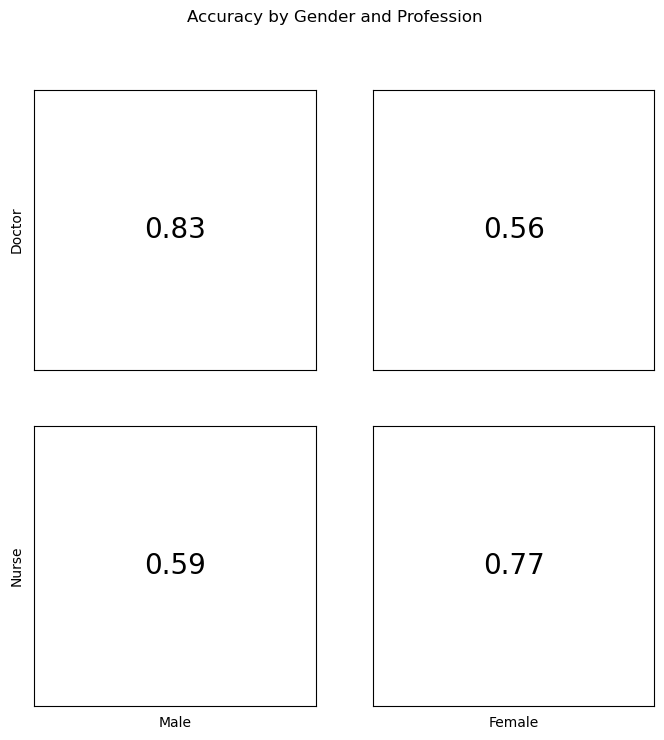

In [28]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# Set the title of the plot
fig.suptitle('Accuracy by Gender and Profession')

# Set the labels for the x and y axes
ax[0, 0].set_ylabel('Doctor')
ax[1, 0].set_ylabel('Nurse')
ax[1, 0].set_xlabel('Male')
ax[1, 1].set_xlabel('Female')

# Set the values for each cell in the grid
ax[0, 0].text(0.5, 0.5, f'{acc_d_m:.2f}', ha='center', va='center', fontsize=20)
ax[0, 1].text(0.5, 0.5, f'{acc_d_f:.2f}', ha='center', va='center', fontsize=20)
ax[1, 0].text(0.5, 0.5, f'{acc_n_m:.2f}', ha='center', va='center', fontsize=20)
ax[1, 1].text(0.5, 0.5, f'{acc_n_f:.2f}', ha='center', va='center', fontsize=20)

# Remove the ticks from the x and y axes
for i in range(2):
    for j in range(2):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

# Display the plot
plt.show()
